# Uncertainty Engine SDK example workflows - train & predict

This notebook goes through how you would set up a workflow to train and save a machine-learning model using the `TrainModel` node and then make predictions on new data using the `PredictModel` node. If you haven't yet viewed [`demo_node.ipynb`](./demo_node.ipynb) or [`demo_workflow.ipynb`](./demo_workflow.ipynb) then take a look at them first as they take you through the basics of creating nodes and workflows using the Uncertainty Engine.

Start by importing and initializing the `Client` (for more details about the client see the `demo_node.ipynb` example). 

In [ ]:
from uncertainty_engine.client import Client

client = Client(
    email="<your-email>",  # Note: There must be token associated with this email.
    deployment="<a-deployment-url>",
)

## Part 1: Building and running a **train** workflow

### Viewing the nodes

Once you have initialised the Uncertainty Engine client you can use the `list_nodes` method to view the available nodes.

In [2]:
 # Create a dictionary with node IDs as keys
nodes = client.list_nodes()
nodes_by_id = {node["id"]: node for node in nodes}

# Print a list of all the node IDs
print(sorted(nodes_by_id.keys()))

['Add', 'AnalyseVariance', 'AppendDataset', 'BuildSensorDesigner', 'CoralScop', 'CreateChat', 'CreateDatasetSlice', 'CreateFEM', 'CustomPython', 'Dict', 'Display', 'Download', 'EmbeddingsConfig', 'FilterDataset', 'GetContext', 'Join', 'KaustWP6PH', 'LLMConfig', 'Load', 'LoadChatHistory', 'LoadDataset', 'LoadDocument', 'LoadModel', 'LoadMultiple', 'Message', 'ModelConfig', 'Number', 'PcdProcessing', 'PredictModel', 'PromptLLM', 'Recommend', 'Save', 'ScoreModel', 'ScoreSensorDesign', 'SimpleLLM', 'Splitter', 'StereoReconstruction', 'SuggestSensorDesign', 'Text', 'TrainModel', 'UncertaintyPlot', 'Workflow']


Once you have found your required node it can be useful to view its information, fields such as the `description`, `inputs` and `outputs` are particularly useful for building your workflow.

In [3]:
from pprint import pprint

# Print the details of the `TrainModel` node
train_node_info = nodes_by_id["TrainModel"]
pprint(train_node_info)

{'cache_url': 'redis-13325.c338.eu-west-2-1.ec2.redns.redis-cloud.com',
 'category': 'MachineLearningModels',
 'cost': 5,
 'description': 'Train a machine-learning model',
 'id': 'TrainModel',
 'image_name': 'uncertainty-engine-train-model-node',
 'inputs': {'config': {'default': None,
                       'description': 'Configuration for the model',
                       'label': 'Model Config',
                       'required': True,
                       'set_in_node': False,
                       'type': 'ModelConfig'},
            'inputs': {'default': None,
                       'description': 'Input dataset for training the model',
                       'label': 'Input Dataset',
                       'required': True,
                       'set_in_node': True,
                       'type': 'CSVDataset'},
            'outputs': {'default': None,
                        'description': 'Output dataset for training the model',
                        'label': 'Output Dat

Now we know that the `TrainModel` node needs the following inputs:
- **Input Dataset:** Train input data
- **Output Dataset:** Target output data
- **Model Config:** A model config node specifying the parameters we wish to use for training

### Creating our train data

In this example we will use some random data to demonstrate how it can be used to train a model. 

We're using the Forrester function as our "ground truth" target function and then 12 randomly sampled points with added Gaussian noise (σ=0.1) as our training data.

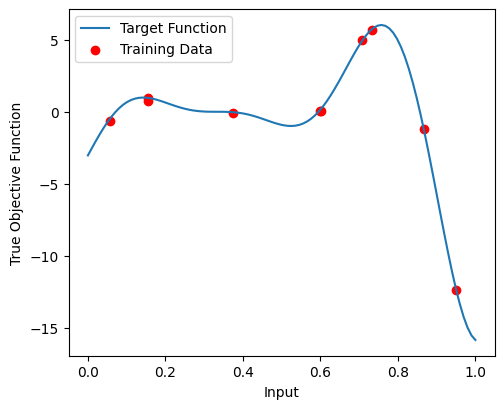

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility and assign number of rows
n_rows = 10
np.random.seed(42)

# Target function: forrester function
def f(x, a=6, b=12):
    return -((a * x - 2) ** 2) * np.sin(b * x - 4)

X = np.linspace(0, 1, 100)[:, np.newaxis]
y = f(X)  # Arrange outputs as feature columns

# Set up training data dataframe
X_data = np.random.uniform(0, 1, size=n_rows) # 12 random points
y_data = f(X_data) + np.random.normal(scale=0.1, size=X_data.shape) # Add noise to the target function

# Plot
plt.figure(figsize=(5.5, 4.5))
plt.plot(X, y, label="Target Function")
plt.scatter(X_data, y_data, color="red", label="Training Data")
plt.xlabel("Input")
plt.ylabel("True Objective Function")
plt.legend()
plt.show()

# Create a pandas DataFrame for training and testing data
train_df = pd.DataFrame({
    'x': X_data,
    'y': y_data
})
test_df = pd.DataFrame({"x": X.flatten(), "y": y.flatten()})

### Constructing a workflow

First, import and initialize the `Graph` class.


In [5]:
from uncertainty_engine.graph import Graph

# Create a new graph
train_graph = Graph()

As we can see by the `TrainModel` node info, it needs a `ModelConfig`. If we print out its information we can see what it's inputs and outputs are.

In [6]:
# Print `ModelConfig` node details
model_config_info = nodes_by_id["ModelConfig"]
pprint(model_config_info)

{'cache_url': 'redis-13325.c338.eu-west-2-1.ec2.redns.redis-cloud.com',
 'category': 'MachineLearningModels',
 'cost': 1,
 'description': 'Config for a machine learning model',
 'id': 'ModelConfig',
 'image_name': 'uncertainty-engine-model-config-node',
 'inputs': {'input_retained_dimensions': {'default': None,
                                          'description': 'Number of dimensions '
                                                         'to retain in the '
                                                         'input data',
                                          'label': 'Input Retained Dimensions',
                                          'required': False,
                                          'set_in_node': True,
                                          'type': 'int'},
            'input_variance': {'default': None,
                               'description': 'Percentage of variance to '
                                              'retain in the input data',

The `ModelConfig` node accepts several optional parameters that control model training. However, as none of the inputs are required we can just use the default input parameters for now. This will configure our model as a `SingleTaskGP` which is ideal for our regression task. A `SingleTaskGP` (Single Task Gaussian Process) models the relationship between a single input and output variable while providing uncertainty estimates alongside predictions.

In [7]:
from uncertainty_engine.nodes.base import Node

# Define the model config node
model_config = Node(
    node_name="ModelConfig",
    label="Model Config",
)

# Add node to the graph and connect it to the train node
train_graph.add_node(model_config)

# Add a handle to the the config output
output_config = model_config.make_handle("config")

Then we can start adding nodes to the graph. The first node we will add is the `TrainModel` node, with our train `x` and `y` CSVs as inputs.

In [8]:
from io import StringIO

# Convert X values to CSV string
x_buffer = StringIO()
train_df[['x']].to_csv(x_buffer, index=False)
x_csv = x_buffer.getvalue()

# Convert Y values to CSV string
y_buffer = StringIO()
train_df[['y']].to_csv(y_buffer, index=False)
y_csv = y_buffer.getvalue()

# Create the train node with the data as input
train_model = Node(
    node_name="TrainModel",
    label="Train Model",
    config=output_config,
    inputs={"csv": x_csv},
    outputs={"csv": y_csv}
)

# Add the node to the graph
train_graph.add_node(train_model)

### Assigning an output node

Now our graph has been built we can use an output node to decide how we wish to collect the output. The output nodes we can use here are:
- **Display:** To view the trained model JSON directly in the workflow outputs.
- **Download:** To download the model JSON using an AWS pre-signed url.
- **Save:** To save the model JSON to the Uncertainty Engine cloud.

First lets make a handle for the output `model` of the `Train` node.

In [9]:
output_model = train_model.make_handle("model")

In this case we will use the `Download` node to get a pre-signed URL for our trained model so we can use it for the `Predict` part of this notebook.

In [10]:
# Define the Download node
download = Node(
  node_name="Download",
  label="Download",
  file=output_model
)

# Add the download node to the graph and connect it to the train node
train_graph.add_node(download)

# Print graph to check the structure
pprint(train_graph.nodes)

{'nodes': {'Download': {'inputs': {'file': {'node_handle': 'model',
                                            'node_name': 'Train Model'}},
                        'type': 'Download'},
           'Model Config': {'inputs': {}, 'type': 'ModelConfig'},
           'Train Model': {'inputs': {'config': {'node_handle': 'config',
                                                 'node_name': 'Model Config'},
                                      'inputs': {'node_handle': 'Train '
                                                                'Model_inputs',
                                                 'node_name': '_'},
                                      'outputs': {'node_handle': 'Train '
                                                                 'Model_outputs',
                                                  'node_name': '_'}},
                           'type': 'TrainModel'}}}


### Executing a workflow

Create the executable workflow by wrapping our graph in the `Workflow` node and defining the `requested_output` as the output handle of the `Download` node.

In [11]:
from uncertainty_engine.nodes.workflow import Workflow

# Wrap the graph in a workflow node
train_workflow = Workflow(
    graph=train_graph.nodes,
    input=train_graph.external_input,
    external_input_id=train_graph.external_input_id,
    requested_output={
        "Trained Model": {"node_name":"Download", "node_handle":"file"},
        }
    )

Now, we can execute the workflow by running `client.run_node(workflow)` and passing the workflow object. This may take a minute for training.

In [12]:
train_response = client.run_node(train_workflow)

Above you will see the URL to our trained model printed under `outputs`. Following the presigned URL will download the trained model. This model can be saved locally and used in the `Predict` part of the notebook by running the following cell.

In [13]:
import requests

# Get the presigned URL from the response
trained_model_url = train_response["outputs"]["outputs"]["Trained Model"]

def get_presigned_url(url):
    """
    Get the contents from the presigned url.
    """
    url = url.replace("https://", "http://")
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    return response

# Get the model from the presigned URL
model_response = get_presigned_url(trained_model_url)
model_json = model_response.json()

## Part 2: Building and running a **predict** workflow

Next, we will use the saved model json to make predictions on a sample dataset. If we take a look at the `PredictModel` node information we can see that the following inputs are needed to run the node:
- **Dataset:** The input data on which to make the output predictions (this will be our `test_df` dataset)
- **Model:** The pre-trained model to be used to make the predictions
- **Seed (optional):** A random seed for reproducibility

In [14]:
# Print `PredictModel` node details
predict_node_info = nodes_by_id["PredictModel"]
pprint(predict_node_info)

{'cache_url': 'redis-13325.c338.eu-west-2-1.ec2.redns.redis-cloud.com',
 'category': 'MachineLearningModels',
 'cost': 5,
 'description': 'Make predictions using a machine-learning model',
 'id': 'PredictModel',
 'image_name': 'uncertainty-engine-predict-model-node',
 'inputs': {'dataset': {'default': None,
                        'description': 'Dataset for predictions',
                        'label': 'Dataset',
                        'required': True,
                        'set_in_node': False,
                        'type': 'CSVDataset'},
            'model': {'default': None,
                      'description': 'Machine-learning model',
                      'label': 'Model',
                      'required': True,
                      'set_in_node': False,
                      'type': 'MachineLearningModel'},
            'seed': {'default': None,
                     'description': 'Random seed for reproducibility',
                     'label': 'Seed',
                  

Now we know what input parameters the `PredictModel` node needs we can start constructing our workflow.

### Constructing the workflow

Let's create a new instance of the `Graph` class (as we don't wish to build on top of our train workflow) and add our predict node using our local `trained_model.json` as the `model` and the `x` column of our `test_df` as the `dataset` we wish to make predictions on.

In [15]:
# Initialise the predict graph
predict_graph = Graph()

# Convert test values to CSV string
test_x_buffer = StringIO()
test_df[['x']].to_csv(test_x_buffer, index=False)
test_x_csv = test_x_buffer.getvalue()

# Define predict node with test data as input dataset and model json as model
predict = Node(
    node_name="PredictModel",
    label="Predict",
    dataset={"csv": test_x_csv},
    model=model_json,
    seed=42,
)

# Add the predict node to the graph
predict_graph.add_node(predict)

We can use the `Download` node to get our resulting datasets. We will need one `Download` node for both the predictions and uncertainty output.

In [16]:
# Add handles to the prediction and uncertainty outputs
output_predictions = predict.make_handle("prediction")
output_uncertainty = predict.make_handle("uncertainty")

# Define download nodes for predictions and uncertainty
display_predictions = Node(
    node_name="Download",
    label="Download Predictions",
    file=output_predictions
)
display_uncertainty = Node(
    node_name="Download",
    label="Download Uncertainty",
    file=output_uncertainty
)

# Add download nodes to the graph and connect them to the predict node
predict_graph.add_node(display_predictions)
predict_graph.add_node(display_uncertainty)

# Print the predict graph
pprint(predict_graph.nodes)

{'nodes': {'Download Predictions': {'inputs': {'file': {'node_handle': 'prediction',
                                                        'node_name': 'Predict'}},
                                    'type': 'Download'},
           'Download Uncertainty': {'inputs': {'file': {'node_handle': 'uncertainty',
                                                        'node_name': 'Predict'}},
                                    'type': 'Download'},
           'Predict': {'inputs': {'dataset': {'node_handle': 'Predict_dataset',
                                              'node_name': '_'},
                                  'model': {'node_handle': 'Predict_model',
                                            'node_name': '_'},
                                  'seed': {'node_handle': 'Predict_seed',
                                           'node_name': '_'}},
                       'type': 'PredictModel'}}}


### Executing the workflow

Now we can run our workflow using the `Workflow` node.

In [17]:
# Wrap the predict graph in a workflow node
predict_workflow = Workflow(
    graph=predict_graph.nodes,
    input=predict_graph.external_input,
    external_input_id=predict_graph.external_input_id,
    requested_output={
        "Predictions": {"node_name":"Download Predictions", "node_handle":"file"},
        "Uncertainty": {"node_name":"Download Uncertainty", "node_handle":"file"},
        }
    )

# Run the predict workflow and get the response
predict_response = client.run_node(predict_workflow)

We can download the results and save the `predictions` and `uncertainty` as pandas dataframes so that we can plot them.

In [18]:
# Download the predictions and save as a DataFrame
predictions_response = get_presigned_url(predict_response["outputs"]["outputs"]["Predictions"])
predictions_df = pd.read_csv(StringIO(predictions_response.text)) # Save the predictions to a DataFrame

# Download the uncertainty and save as a DataFrame
uncertainty_response = get_presigned_url(predict_response["outputs"]["outputs"]["Uncertainty"])
uncertainty_df = pd.read_csv(StringIO(uncertainty_response.text)) # Save the uncertainty to a DataFrame

### Plot the results

Finally, we can plot our predictions vs our truth function. 

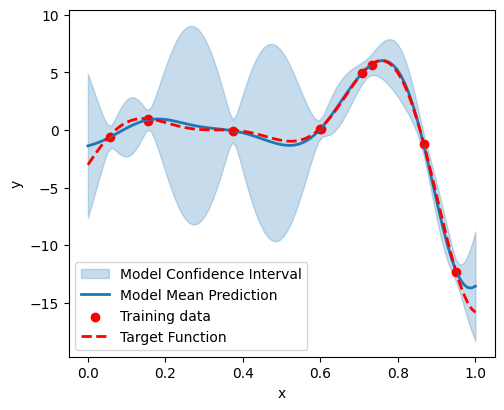

In [19]:
CONFIDENCE_99_ZSCORE = 2.58  # z-score for 99% confidence interval

x_plot = test_df["x"].to_numpy()
y_pred = predictions_df.to_numpy().flatten()
y_std = uncertainty_df.to_numpy().flatten()

plt.figure(figsize=(5.5, 4.5))

plt.fill_between(
    x_plot,
    (y_pred - CONFIDENCE_99_ZSCORE * y_std),
    (y_pred + CONFIDENCE_99_ZSCORE * y_std),
    color="C0",
    alpha=0.25,
    label="Model Confidence Interval",
)
plt.plot(X, y_pred, c="C0", linewidth=2, label="Model Mean Prediction")

plt.scatter(
    train_df["x"],
    train_df["y"],
    color="red",
    label="Training data",
)
plt.xlabel("x")
plt.ylabel("y")

plt.plot(X, y, c="r", linewidth=2, linestyle="dashed", label="Target Function")
plt.legend()
plt.show()

### Conclusion

As you can see by the plot, the model is able to predict the target function accurately. The confidence interval is also shown, which indicates the uncertainty in the model's predictions. 
- **Areas of high confidence:** Near training points, the confidence bands narrow significantly, showing the model's certainty in these regions.
- **Areas of high uncertainty:** Between x=0.3 and x=0.5, we observe notably wider confidence bands, reflecting the model's increased uncertainty due to the sparse sampling in this region. We can see that at the edges the uncertainty increases as well. This edge behaviour is characteristic of Gaussian Processes, as the model lacks training points beyond these boundaries to constrain its predictions.

The uncertainty could probably be decreased by adding more training points between x=0.3 and x=0.5.

In this notebook we have demonstrated how to use the SDK to train a model and then use it to make predictions. 

If you wanted to lead on from this and get a more accurate reading of how well the model performed you could try using the `ScoreModel` node to evaluate the model. Otherwise, checkout [`demo_resource.ipynb`](./demo_resource.ipynb) to learn about how you can use resources in the Uncertainty Engine SDK.